# AnimeGAN

## 初始化

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *
import time
import cv2
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
print("1")

1


In [3]:
base = BaseOverlay("base.bit")
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()
# monitor (output) frame buffer size
frame_out_w = 1920
frame_out_h = 1080
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480
# initialize camera from OpenCV
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
if(videoIn.isOpened()):
    print("Capture device is open: " + str(videoIn.isOpened()))
    img = cv2.imread('/home/xilinx/jupyter_notebooks/AnimeGAN/开始界面.png')
    #在图片上添加文字信息
    frame = cv2.resize(img,(640,480))
    # cv2.putText(frame, "Hello Vertira",(320, 240), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
    outframe = hdmi_out.newframe()
    outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
    hdmi_out.writeframe(outframe)
else:
    print("Capture device is open: " + str(videoIn.isOpened()))
print(2)

Capture device is open: True
2


In [3]:
#hdmi_out.stop()
#del hdmi_out

In [10]:
img = cv2.imread('/home/xilinx/jupyter_notebooks/AnimeGAN/开始界面.png')
#在图片上添加文字信息
frame = cv2.resize(img,(640,480))
# cv2.putText(frame, "Hello Vertira",(320, 240), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
outframe = hdmi_out.newframe()
outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
hdmi_out.writeframe(outframe)

## 模型函数

In [5]:
class ConvNormLReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, pad_mode="reflect", groups=1, bias=False):
        
        pad_layer = {
            "zero":    nn.ZeroPad2d,
            "same":    nn.ReplicationPad2d,
            "reflect": nn.ReflectionPad2d,
        }
        if pad_mode not in pad_layer:
            raise NotImplementedError
            
        super(ConvNormLReLU, self).__init__(
            pad_layer[pad_mode](padding),
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=0, groups=groups, bias=bias),
            nn.GroupNorm(num_groups=1, num_channels=out_ch, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )


class InvertedResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, expansion_ratio=2):
        super(InvertedResBlock, self).__init__()

        self.use_res_connect = in_ch == out_ch
        bottleneck = int(round(in_ch*expansion_ratio))
        layers = []
        if expansion_ratio != 1:
            layers.append(ConvNormLReLU(in_ch, bottleneck, kernel_size=1, padding=0))
        
        # dw
        layers.append(ConvNormLReLU(bottleneck, bottleneck, groups=bottleneck, bias=True))
        # pw
        layers.append(nn.Conv2d(bottleneck, out_ch, kernel_size=1, padding=0, bias=False))
        layers.append(nn.GroupNorm(num_groups=1, num_channels=out_ch, affine=True))

        self.layers = nn.Sequential(*layers)
        
    def forward(self, input):
        out = self.layers(input)
        if self.use_res_connect:
            out = input + out
        return out

    
class Generator(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        self.block_a = nn.Sequential(
            ConvNormLReLU(3,  32, kernel_size=7, padding=3),
            ConvNormLReLU(32, 64, stride=2, padding=(0,1,0,1)),
            ConvNormLReLU(64, 64)
        )
        #input [c,h,w]->[c,h+6,w+6]
        
        self.block_b = nn.Sequential(
            ConvNormLReLU(64,  128, stride=2, padding=(0,1,0,1)),            
            ConvNormLReLU(128, 128)
        )
        
        self.block_c = nn.Sequential(
            ConvNormLReLU(128, 128),
            InvertedResBlock(128, 256, 2),
            InvertedResBlock(256, 256, 2),
            InvertedResBlock(256, 256, 2),
            InvertedResBlock(256, 256, 2),
            ConvNormLReLU(256, 128),
        )    
        
        self.block_d = nn.Sequential(
            ConvNormLReLU(128, 128),
            ConvNormLReLU(128, 128)
        )

        self.block_e = nn.Sequential(
            ConvNormLReLU(128, 64),
            ConvNormLReLU(64,  64),
            ConvNormLReLU(64,  32, kernel_size=7, padding=3)
        )

        self.out_layer = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input, align_corners=True):
        print('-'*50)
        print("begin 1")
        a = time.time()
        s = a
        out = self.block_a(input)
        b = time.time()
        print("block_a time",b-a)
        print("block_a size",out.shape)
        print('-'*50)
        print("begin 2")
        
#         half_size = out.size()[-2:]
#         print("begin 3")
        a = time.time()
        out = self.block_b(out)
        b = time.time()
        print("block_b time",b-a)
        print("block_b size",out.shape)
        print('-'*50)
        print("begin 3")
        a = time.time()
        out = self.block_c(out)
        b = time.time()
        print("block_c time",b-a)
        print("block_c size",out.shape)
        print('-'*50)
        print("begin 4")
        
        a = time.time()
        if align_corners:
            out = F.interpolate(out, half_size, mode="bilinear", align_corners=True)
        else:
            out = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
        b = time.time()
        print("F.interpolate time",b-a)
        print("F.interpolate size",out.shape)
        print('-'*50)
        print("begin 5")
        a = time.time()
        out = self.block_d(out)
        b = time.time()
        print("block_d time",b-a)
        print("block_d size",out.shape)
        print('-'*50)
        print("begin 6")
        
        a = time.time()
        if align_corners:
            out = F.interpolate(out, input.size()[-2:], mode="bilinear", align_corners=True)
        else:
            out = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
        b = time.time()
        print("F.interpolate time",b-a)
        print("F.interpolate size",out.shape)
        print('-'*50)
        print("begin 7")
        img = cv2.imread('./等待界面2.png')
        frame = cv2.resize(img,(640,480))
        #要注意这里不是通过array或者list格式输出的，为video包中的专属格式
        outframe = hdmi_out.newframe()
        outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
        hdmi_out.writeframe(outframe)
        a = time.time()
        out = self.block_e(out)
        b = time.time()
        print("block_e time",b-a)
        print("block_e size",out.shape)
        print('-'*50)
        print("begin 8")
        
        a = time.time()
        out = self.out_layer(out)
        b = time.time()
        print("block_d time",b-a)
        print("block_d size",out.shape)
        print('-'*50)
        print("begin 9")
        print("total time",b-s)
        return out

In [6]:
def load_image(image_path, x32=False):
    img = Image.open(image_path).convert("RGB")

    if x32:
        def to_32s(x):
            return 256 if x < 256 else x - x % 32
        w, h = img.size
        img = img.resize((to_32s(w), to_32s(h)))

    return img
def test(checkpoint='./weights/face_paint_512_v2.pt',input_dir='./samples/camera/',output_dir='./samples/camera_result',upsample_align=False):
    device = 'cpu'
    net = Generator()
    print("1")
    net.load_state_dict(torch.load(checkpoint, map_location="cpu"))
    net.to(device).eval()
    print(f"model loaded: {checkpoint}")
    
    os.makedirs(output_dir, exist_ok=True)
    img = cv2.imread('./等待界面.png')
    frame = cv2.resize(img,(640,480))
    #要注意这里不是通过array或者list格式输出的，为video包中的专属格式
    outframe = hdmi_out.newframe()
    outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
    hdmi_out.writeframe(outframe)
    for image_name in sorted(os.listdir(input_dir)):
        print("2")
        if os.path.splitext(image_name)[-1].lower() not in [".jpg", ".png", ".bmp", ".tiff"]:
            continue
            
        print(os.path.join(input_dir, image_name))
        image = load_image(os.path.join(input_dir, image_name))
        a,b = image.size
        if(a>b):
            image = image.resize((224,int(224/(a/b))))
        else:
            image = image.resize((int(224/(b/a)),224))
        print("3")
        print("image size : ",image.size)
        
        with torch.no_grad():
            image = to_tensor(image).unsqueeze(0) * 2 - 1
            print("4")
            out = net(image.to(device), upsample_align).cpu()
            print("5")
            out = out.squeeze(0).clip(-1, 1) * 0.5 + 0.5
            out = to_pil_image(out)

        out.save(os.path.join(output_dir, image_name))
        print("6")
        print(f"image saved: {image_name}")
        img =cv2.imread(os.path.join(input_dir, image_name)) # 待处理的图片地址, 替换成你的地址就好
        img2 =cv2.imread(os.path.join(output_dir, image_name)) # 待处理的图片地址, 替换成你的地址就好

        if(img.shape[0]<img.shape[1]):
            target_size=[240,640] # 目标图像大小
            img = resize_img_keep_ratio(img, target_size) 
            img2 = resize_img_keep_ratio(img2, target_size) 
            new_img = np.concatenate([img2, img], axis=0)
        else:
            target_size=[480,320] # 目标图像大小
            img = resize_img_keep_ratio(img, target_size) 
            img2 = resize_img_keep_ratio(img2, target_size) 
            new_img = np.concatenate([img2, img], axis=1)
        
        plt.imshow(new_img)

        plt.title(" Anime--->Image ",fontsize=15,c="royalblue")
        plt.axis ('off') 
        plt.savefig(os.path.join(output_dir, image_name[:-3]+"png"))
        plt.show()
        outframe = hdmi_out.newframe()
        outframe[0:480,0:640,:] = new_img[0:480,0:640,[2,1,0]]
        hdmi_out.writeframe(outframe)

In [7]:
def photo():
    flag = 1
    start = time.time()

    while (flag):
        ret, frame_vga = videoIn.read()
        cur_time = time.time()
#         print(ret)
        if(int(cur_time-start)==3):
            flag=0
        if (ret):      
            outframe = hdmi_out.newframe()
            outframe[0:480,0:640,:] = frame_vga[0:480,0:640,:]
            cv2.putText(outframe, " Countdown Timer"+str(int(cur_time-start))+"s",(0, 50), cv2.FONT_HERSHEY_PLAIN, 2.0, (29, 147, 219), 2)
            hdmi_out.writeframe(outframe)
        else:
            raise RuntimeError("Failed to read from camera.")
    outframe = hdmi_out.newframe()
    outframe[0:480,0:640,:] = frame_vga[0:480,0:640,:]
    cv2.putText(outframe, " Happy with the photo？",(0, 50), cv2.FONT_HERSHEY_PLAIN, 2.0, (29, 147, 219), 2)
    hdmi_out.writeframe(outframe)
    happy=input(" Happy with the photo？")
    return happy,frame_vga
# 封装resize函数
def resize_img_keep_ratio(img,target_size):
#     img = cv2.imread(img_name) # 读取图片
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
    old_size= img.shape[0:2] # 原始图像大小
    ratio = min(float(target_size[i])/(old_size[i]) for i in range(len(old_size))) # 计算原始图像宽高与目标图像大小的比例，并取其中的较小值
    new_size = tuple([int(i*ratio) for i in old_size]) # 根据上边求得的比例计算在保持比例前提下得到的图像大小
    img = cv2.resize(img,(new_size[1], new_size[0])) # 根据上边的大小进行放缩
    pad_w = target_size[1] - new_size[1] # 计算需要填充的像素数目（图像的宽这一维度上）
    pad_h = target_size[0] - new_size[0] # 计算需要填充的像素数目（图像的高这一维度上）
    top,bottom = pad_h//2, pad_h-(pad_h//2)
    left,right = pad_w//2, pad_w -(pad_w//2)
    img_new = cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT,None,(255,255,255)) 
    return img_new

def main(scenery,from_camera,pic_address=None,output_dir='./samples/trans_results'):
    if(scenery=='1'):
        model_weight = './weights/paprika.pt'
    elif(scenery=='0'):
        model_weight = './weights/face_paint_512_v2.pt'
    else:
        model_weight = './weights/paprika.pt'
    if(from_camera=='1'):
        input_dir = "./samples/need_trans/"
    else:
        input_dir = os.path.dirname(pic_address)
    if(from_camera=='1'):
        happy=0
        while(happy!='1'):
            happy,frame_vga = photo()
            outframe = hdmi_out.newframe()
            outframe[0:480,0:640,:] = frame_vga[0:480,0:640,:]
            hdmi_out.writeframe(outframe)
        
    if(scenery!='1'):
        if(from_camera=="1"):
            np_frame = frame_vga
        else:
            np_frame =  cv2.imread(pic_address)

        face_cascade = cv2.CascadeClassifier(
            '/home/xilinx/jupyter_notebooks/base/video/data/'
            'haarcascade_frontalface_default.xml')
        eye_cascade = cv2.CascadeClassifier(
            '/home/xilinx/jupyter_notebooks/base/video/data/'
            'haarcascade_eye.xml')

        gray = cv2.cvtColor(np_frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        i=20
        for (x,y,w,h) in faces:
            new = np_frame[int(y*0.3):int(y+h*1.1),int(x):int(x+w),:]
            path = "./samples/need_trans/"+str(i)+'.jpg'
            i+=1
            cv2.imwrite(path, new)     # 将图片保存为本地文件
            plt.axis ('off') 
            plt.imshow(new[:,:,[2,1,0]])
            plt.show()
            img = cv2.imread(path)

            #在图片上添加文字信息
#             frame = cv2.resize(img,(640,480))
            frame = resize_img_keep_ratio(img,(480,640))
            cv2.putText(frame, "The Portrait will be transport:",(10, 50), cv2.FONT_HERSHEY_PLAIN, 2.0, (0, 0, 255), 2)
        
            outframe = hdmi_out.newframe()
            outframe[0:480,0:640,:] = frame[0:480,0:640,[2,1,0]]
            hdmi_out.writeframe(outframe)
            time.sleep(3)

            
    start = time.time()
    test(checkpoint=model_weight,input_dir=input_dir,output_dir=output_dir,upsample_align=False)
    end = time.time()
    print(end-start," s")

## 参数配置

What type do you want to transport? 
Put 1 for Senery 0 for Portrait	1
Do you want take a photo now or select a picture from folder? 
Put 0 for from folder 1 for take a picture now1
 Happy with the photo？1
1
model loaded: ./weights/paprika.pt
2
./samples/need_trans/ 20.jpg
3
image size :  (163, 224)
4
--------------------------------------------------
begin 1
block_a time 16.795429944992065
block_a size torch.Size([1, 64, 112, 81])
--------------------------------------------------
begin 2
block_b time 12.356625318527222
block_b size torch.Size([1, 128, 56, 40])
--------------------------------------------------
begin 3
block_c time 79.72693181037903
block_c size torch.Size([1, 128, 56, 40])
--------------------------------------------------
begin 4
F.interpolate time 0.29700255393981934
F.interpolate size torch.Size([1, 128, 112, 80])
--------------------------------------------------
begin 5
block_d time 63.696441411972046
block_d size torch.Size([1, 128, 112, 80])
------------------

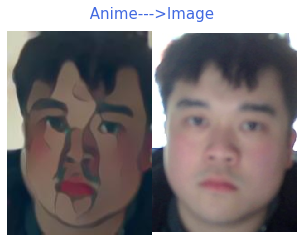

512.5453016757965  s


In [18]:
img = cv2.imread('/home/xilinx/jupyter_notebooks/AnimeGAN/信息界面.png')
#在图片上添加文字信息
frame = cv2.resize(img,(640,480))
scenery = input("What type do you want to transport? \nPut 1 for Senery 0 for Portrait\t")
#在图片上添加文字信息
# frame = cv2.resize(img,(640,480))
if(scenery=='1'):
    cv2.putText(frame, "Scenery or Portrait?",(40, 100), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    cv2.putText(frame, "You choose Scenery",(40, 150), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 225, 255), 2)
else:
    cv2.putText(frame, "Scenery or Portrait?",(40, 100), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    cv2.putText(frame, "You choose Portrait",(40, 150), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 225, 255), 2)
outframe = hdmi_out.newframe()
outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
hdmi_out.writeframe(outframe)
from_camera = input("Do you want take a photo now or select a picture from folder? \nPut 0 for from folder 1 for take a picture now")
if(from_camera=='1'):
    cv2.putText(frame, "Take a photo or Select one from folder?",(40, 200), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    cv2.putText(frame, "You choose take photo now",(40, 250), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 255), 2)
else:
    cv2.putText(frame, "Take a photo or Select one from folder?",(40, 200), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    cv2.putText(frame, "You choose to get a photo from folder",(40,250), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 225, 255), 2)
outframe = hdmi_out.newframe()
outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
hdmi_out.writeframe(outframe)
hdmi_out.writeframe(outframe)
if(from_camera=="0"):
    pic_address = input("Please input the address of the picture which you want to transport:")
    cv2.putText(frame, "The address is "+pic_address,(40,300), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    outframe = hdmi_out.newframe()
    outframe[0:480,0:640,:] = frame[0:480,0:640,[0,1,2]]
    hdmi_out.writeframe(outframe)
else:
    pic_address= None
main(scenery,from_camera,pic_address)